In [1]:
import tensorflow as tf

In [2]:
# input_file = "c:/workspace/tibert/tibert/albert_pretrain/test-data/test_favor_short.tf_record"
# input_file = "c:/workspace/tibert/tibert/albert_pretrain/test-data/test_favor_long.tf_record"
# input_file = "c:/workspace/tibert/tibert/albert_pretrain/test-data/test_favor_long_20_prob.tf_record"
# input_file = "c:/workspace/tibert/tibert/albert_pretrain/test-data/test_favor_4gram.tf_record"
# input_file = "c:/workspace/tibert/tibert/albert_pretrain/test-data/test_favor_long_no_stoch.tf_record"

input_file = "c:/workspace/tibert_data/test-data/sample-harder-datasets/test_favor_long_no_stoch.tf_record"

# input_file = "c:/workspace/tibert_data/test-data/original-run/*.tf_record"
# input_file = "c:/workspace/tibert_data/test-data/endogenous-docs/*.tf_record"

In [3]:
input_files = []
for input_pattern in input_file.split(","):
    input_files.extend(tf.gfile.Glob(input_pattern))
input_files

['c:\\workspace\\tibert_data\\test-data\\sample-harder-datasets\\test_favor_long_no_stoch.tf_record']

In [4]:
d = tf.data.TFRecordDataset(input_files)

In [5]:
max_seq_length, max_predictions_per_seq, batch_size = 128, 20, 16

In [6]:
name_to_features = {
    "input_ids": tf.FixedLenFeature([max_seq_length], tf.int64),
    "input_mask": tf.FixedLenFeature([max_seq_length], tf.int64),
}

# if FLAGS.masked_lm_budget:
#   name_to_features.update({
#       "token_boundary":
#           tf.FixedLenFeature([max_seq_length], tf.int64)})
# else:
name_to_features.update({
  "masked_lm_positions":
      tf.FixedLenFeature([max_predictions_per_seq], tf.int64),
  "masked_lm_ids":
      tf.FixedLenFeature([max_predictions_per_seq], tf.int64),
  "masked_lm_weights":
      tf.FixedLenFeature([max_predictions_per_seq], tf.float32)})

In [7]:
def _decode_record(record, name_to_features):
  """Decodes a record to a TensorFlow example."""
  example = tf.parse_single_example(record, name_to_features)

  # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
  # So cast all int64 to int32.
  for name in list(example.keys()):
    t = example[name]
    if t.dtype == tf.int64:
      t = tf.to_int32(t)
    example[name] = t

  return example

In [8]:
d = d.apply(
    tf.data.experimental.map_and_batch_with_legacy_function(
        lambda record: _decode_record(record, name_to_features),
        batch_size=batch_size,
        num_parallel_batches=4,
        drop_remainder=True))

Instructions for updating:
Use `tf.data.experimental.map_and_batch()

Instructions for updating:
Use `tf.cast` instead.


In [9]:
next_item_iter = d.make_one_shot_iterator().get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    next_item = sess.run(next_item_iter)

In [11]:
next_item

{'input_ids': array([[   2, 9874, 9955, ...,    4, 1105,    3],
        [   2, 1383,   19, ..., 9955, 4491,    3],
        [   2, 2749,  153, ...,  105, 2178,    3],
        ...,
        [   2,  912,  634, ...,   89, 1488,    3],
        [   2, 2406,  278, ...,  338, 2406,    3],
        [   2, 7662, 9890, ...,    0,    0,    0]]),
 'input_mask': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0]]),
 'masked_lm_ids': array([[ 198, 1019, 9890,  198,  499, 9890, 9874, 9955,  312,  231,  117,
          463, 2109,  251, 9955,  247, 2842,  109, 1105,    0],
        [ 631,  171, 1704,  626,  161, 9874, 9955, 4481,  952, 1019,   88,
         4308,  319, 9955, 1298,  109, 1927,   19, 7009,    0],
        [  10,  794, 2648,  251, 9955, 2864, 6478,  497,  215,  226,  560,
          586,  386, 9907, 9885, 9955,  509,  251,  899,    0],
     

In [12]:
next_item['input_ids'].shape

(16, 128)

In [13]:
import tibert.models.training as training

In [14]:
tibert_tkn = training.make_tokenizer(tokenizer_name="tibert-bpe-large")
tibert_tkn.stochastic_tokenization = False

In [15]:
i = 0

In [16]:
encoded = next_item['input_ids'][i]
print(tibert_tkn.decode(encoded))
i += 1

[CLS] །སྙན་པར་སྨྲ་བ་ནི་བྱང་ཆུབ་ཀྱི་མྱུ་གུ་དང་འདབ་མ་ཡོངས་[MASK][MASK] འབད་པ་འོ། །དོན་སྤྱོད་པ་ནི་བྱང་ཆུབ་ཀྱི་མེ་ཏོག་ཡོངས་ིལ་བ་[MASK][MASK]འོ།[MASK][MASK]དོན་འཐུན་པ་ནི་བྱང་ཆུབ་ཀྱི་འབྲས་བུ་མངོན་པར་འགྲུབ་པ་སྟེ། བཙུན་པ་ཤ་ར་ད[MASK]ཏིའི་བུ། འདི་དག་ནི་བྱང་ཆུབ་སེམས་དཔའ་རྣམས་ཀྱི་བསྡུ་བའི་དངོས་པོ་བཞི་མི་ཟད་པའོ། །བཙུན་པ་ཤ་ར་དྭ་ཏིའི་བུ། གཞན་ཡང་བྱང་ཆུབ་སེམས་དཔའ་རྣམས་[MASK]སོ་སོ་ཡང་དག་པར་རིག་པ་བཞི་མི་ཟད་པ་སྟེ། བཞི་གང་ཞེ་ན། གང་[MASK]དོན་སོ་སོ་ཡང་དག་པར་རིག་པ་[MASK][MASK] བརྙན་སོ་སོ་ཡང་དག་པར་རིག་པ་དང་། ངེས་པའི་ཚིག་སོ་སོ་[MASK][MASK]རིག་པ་[SEP]


# MLM loss of a trained model

In [17]:
import torch
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

In [18]:
import tibert.models.training as training

In [19]:
from transformers import AutoConfig, AlbertForMaskedLM

In [20]:
tibert_mdl = AlbertForMaskedLM.from_pretrained(
    'c:/workspace/tibert_data/training/models/tibert-training-test/682000.bin',
    config=AutoConfig.from_pretrained("albert-base-v2"))
# tibert_mdl = AlbertForMaskedLM.from_pretrained(
#     'c:/workspace/tibert_data/training/models/tibert-champion/676000.bin',
#     config=AutoConfig.from_pretrained("albert-base-v2"))
tibert_mdl.resize_token_embeddings(len(tibert_tkn))

- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(10000, 128)

In [21]:
tibert_mdl = tibert_mdl.cuda().eval()

In [22]:
def prep_batch(next_item):
    input_ids, labels = next_item['input_ids'], np.array([-100 for _ in range(next_item['input_ids'].size)]).reshape(next_item['input_ids'].shape)
    for idx, row in enumerate(input_ids):
        masked_lm_pos = next_item['masked_lm_positions'][idx][:-1]
        labels[idx][masked_lm_pos] = next_item['masked_lm_ids'][idx][:-1]
    return input_ids, labels

In [23]:
def get_ce(input_ids, labels):
    batch = {
        'input_ids': torch.LongTensor(input_ids).to("cuda"),
        'labels': torch.LongTensor(labels).to("cuda")}
    ce, _ = tibert_mdl(**batch)
    return float(ce)

In [24]:
ces = []

In [25]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [26]:
for _ in tqdm(range(1000)):
    next_item = sess.run(next_item_iter)
    input_ids, labels = prep_batch(next_item)
    ces.append(get_ce(input_ids, labels))
pd.Series(ces).describe()

count    1000.000000
mean        1.649080
std         0.403755
min         0.664452
25%         1.352930
50%         1.611231
75%         1.904243
max         3.164315
dtype: float64

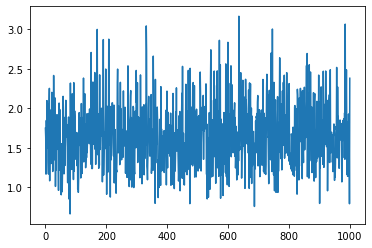

In [27]:
pd.Series(ces).plot()

In [28]:
sess.close()

In [32]:
for _ in tqdm(range(1000)):
    next_item = sess.run(next_item_iter)
    input_ids, labels = prep_batch(next_item)
    ces.append(get_ce(input_ids, labels))
pd.Series(ces).describe()

count    1000.000000
mean        1.774265
std         0.461564
min         0.659495
25%         1.431561
50%         1.739854
75%         2.069431
max         3.517152
dtype: float64

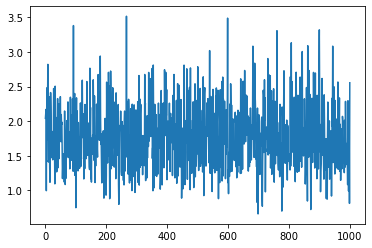

In [33]:
pd.Series(ces).plot()

In [34]:
for _ in tqdm(range(1000)):
    next_item = sess.run(next_item_iter)
    input_ids, labels = prep_batch(next_item)
    ces.append(get_ce(input_ids, labels))
pd.Series(ces).describe()

count    1100.000000
mean        1.632116
std         0.415557
min         0.555048
25%         1.340283
50%         1.586769
75%         1.893252
max         3.414083
dtype: float64

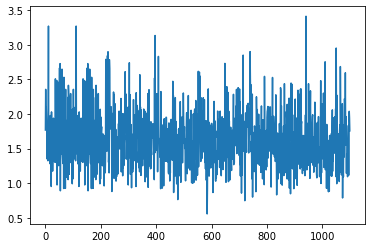

In [35]:
pd.Series(ces).plot()

In [28]:
for _ in tqdm(range(1000)):
    next_item = sess.run(next_item_iter)
    input_ids, labels = prep_batch(next_item)
    ces.append(get_ce(input_ids, labels))
pd.Series(ces).describe()

count    1000.000000
mean        1.360500
std         0.377693
min         0.368257
25%         1.092720
50%         1.316934
75%         1.593485
max         2.798126
dtype: float64

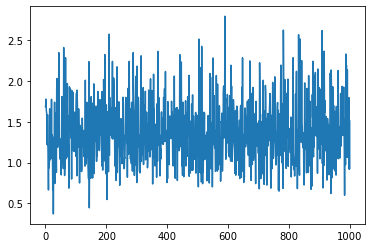

In [29]:
pd.Series(ces).plot()

# Pretraining loss of a trained model

In [34]:
import torch
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

In [35]:
import tibert.models.training as training

In [36]:
from transformers import AutoConfig, AlbertForPreTraining

In [37]:
tibert_mdl = AlbertForPreTraining.from_pretrained(
    'c:/workspace/tibert_data/training/models/tibert-training-test/679000.bin',
    config=AutoConfig.from_pretrained("albert-base-v2"))

# tibert_mdl = AlbertForPreTraining.from_pretrained(
#     'c:/workspace/tibert_data/training/models/tibert-champion/676000.bin',
#     config=AutoConfig.from_pretrained("albert-base-v2"))
tibert_mdl.resize_token_embeddings(len(tibert_tkn))

Embedding(10000, 128)

In [38]:
tibert_mdl = tibert_mdl.cuda().eval()

In [39]:
def prep_batch(next_item):
    input_ids, labels = next_item['input_ids'], np.array([-100 for _ in range(next_item['input_ids'].size)]).reshape(next_item['input_ids'].shape)
    for idx, row in enumerate(input_ids):
        masked_lm_pos = next_item['masked_lm_positions'][idx][:-1]
        labels[idx][masked_lm_pos] = next_item['masked_lm_ids'][idx][:-1]
    return input_ids, labels

In [40]:
from torch.nn import CrossEntropyLoss

def get_ce(input_ids, labels):
    batch = {
        'input_ids': torch.LongTensor(input_ids).to("cuda"),
        'labels': torch.LongTensor(labels).to("cuda"),
        'sentence_order_label': torch.LongTensor(next_item['next_sentence_labels'].squeeze()).to("cuda"),
        'attention_mask': torch.LongTensor(next_item['input_mask']).to("cuda"),
        'token_type_ids': torch.LongTensor(next_item['segment_ids']).to("cuda")}
    ce, _, sop_logits = tibert_mdl(**batch)
    sentence_order_loss = float(CrossEntropyLoss()(sop_logits.view(-1, 2), batch['sentence_order_label'].view(-1)))
    return float(ce) - sentence_order_loss, sentence_order_loss

In [41]:
mlm_ces, sop_ces = [], []

In [42]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [43]:
for _ in tqdm(range(100)):
    next_item = sess.run(next_item_iter)
    input_ids, labels = prep_batch(next_item)
    mlm_ce, sop_ce = get_ce(input_ids, labels)
    mlm_ces.append(mlm_ce)
    sop_ces.append(sop_ce)
res_df = pd.DataFrame({"mlm": mlm_ces, "sop": sop_ces})
res_df.describe()

KeyError: 'next_sentence_labels'

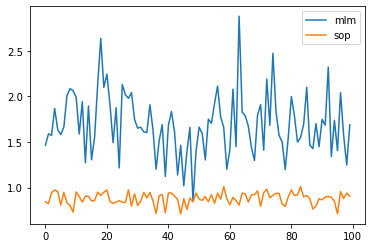

In [27]:
res_df.plot()

In [28]:
sess.close()

# Blank token

In [19]:
tibert_tkn.decode([9874])

''

In [31]:
tibert_tkn.decode([2, 9874, 9955, 4, 4, 9873, 9890, 9877, 9875, 9873, 92, 9891, 15, 626
, 5063, 9902, 9882, 9875, 9955, 3, 9879, 9919, 9887, 9882, 9873, 264, 9886, 9955
, 9874, 9955, 2025, 9888])

'[CLS] །[MASK][MASK]་པོས་སྤྲོ་ཞིང་བརྟེན་པ་ཡིས།[SEP]དྨའི་གདན། །ཇི་ལ'

In [40]:
tibert_tkn.decode([9955, 9874, 9955])

'། །'

In [39]:
tibert_tkn.encode('པོ། །ས')

[2, 257, 9877, 9955, 9874, 9955, 9875, 3]

In [41]:
for batch in next_item['input_ids']:
    if 9874 in batch:
        print(batch)
        break

[   2 9874 9955    4    4 9873 9890 9877 9875 9873   92 9891   15  626
 5063 9902 9882 9875 9955    3 9879 9919 9887 9882 9873  264 9886 9955
 9874 9955 2025 9888    4   13 9875 9908   26  872  149   16 9902 9882
 9955 9874 9955  417  458   76 9881   19 9890 9873  133 9881    9  533
 9888 9955 9874 9955 9876 9906 3160 1291 9879   31  279  251 9955    4
 2274  252 9881  851    4  798 9886 9882 9873  785 9882    4    4 8799
  484  340  488  181    8 1036   75 9882 9955    4 9955 9895   59   89
 5640 9900 9882    9  991 9879   21 1947 9955 9874    4    4    4 9883
 9875 9873 1316 7828  533 9886 9875 9955 9874 9955    4    4    4  951
 2414    3]
